In [3]:
%display typeset

We first define the Van der Pol equation, which depends on a parameter $\mu$.

In [1]:
def vanderpol(mu, omega):
    """
    The Van der Pol oscillator is a non-conservative system with non-linear damping.
    
    
    For additional information see the :wiki:`Van_der_Pol_oscillator`.
    
    EXAMPLES:

        sage: from carlin.library import vanderpol
        sage: vanderpol(1, 1/2)
        [xx, 2, 3]
    """
    # dimension of state-space
    n=2

    # define the vector of symbolic variables
    x = polygens(QQ, ['x'+str(i) for i in range(n)])

    # vector field (n-dimensional)
    f = [None] * n

    f[0] = x[1]
    f[1] = - omega**2 * x[0] + mu * (1 - x[0]**2) * x[1]

    # order of the ODE
    k = 3
    
    return f, n, k

In [2]:
vanderpol(SR('mu'), SR('omega'))

([x1, -omega^2*x0 - (x0^2 - 1)*mu*x1], 2, 3)

We can compute the Carleman linearized ODE at order $N$, and a given numerical value of the parameter $\mu$:

In [8]:
from carlin.transformation import get_Fj_from_model, truncated_matrix, solve_linearized_ode

# parameter in van der pol's equation
mu = 0.8

Fj = get_Fj_from_model(*vanderpol(mu))

# truncation order
N = 2

AN = truncated_matrix(N, *Fj, input_format="Fj_matrices")
AN = matrix(AN.toarray())

In [15]:
# initial condition
x0 = [0.2, 0]

# initial time
tini = 0

# final time
T = 5

# number of computation points
NPOINTS = 400
    
ans = solve_linearized_ode(AN, x0, N, tini, T, NPOINTS)

In [14]:
def solve_linearized_ode(AN, x0, N, tini, T, NPOINTS):

    def initial_state_kron(x0, N):
        from carlin.transformation import kron_power

        y0 = kron_power(x0, 1)
        for i in [2..N]:
            y0 += kron_power(x0, i)
        return vector(y0)

    # transform to x0, x0^[2], ..., x0^[N]
    y0 = initial_state_kron(x0, N)

    # time domain
    from numpy import linspace
    t_dom = linspace(tini, T, num=NPOINTS)

    # compute solution
    sol = [exp(AN*ti)*y0 for ti in t_dom]

    return sol

In [11]:
%%time

# compute solution
sol = [exp(AN*ti)*y0 for ti in t_dom]

CPU times: user 168 ms, sys: 2.44 ms, total: 170 ms
Wall time: 172 ms


In [12]:
sol_x1 = [sol[i][0] for i in range(NPOINTS)]
sol_x2 = [sol[i][1] for i in range(NPOINTS)]

/Users/forets/Tools/sage-master/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


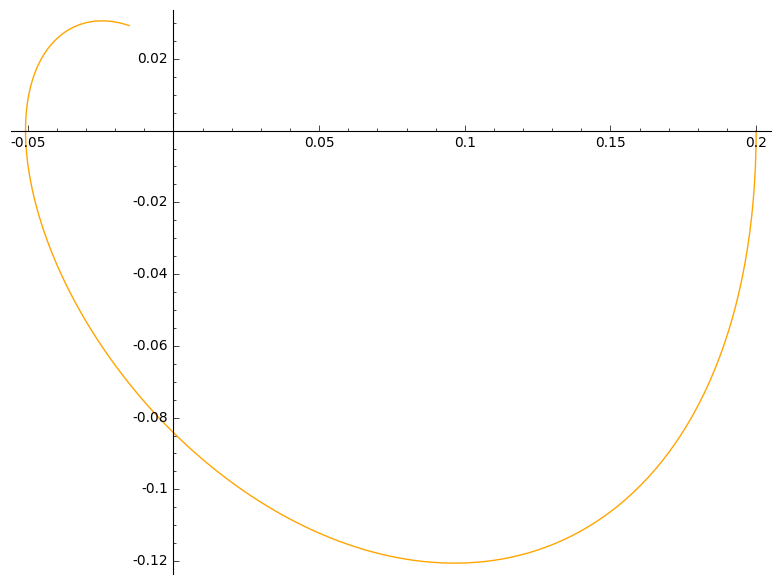

In [13]:
Graphic2 = list_plot(zip(sol_x1, sol_x2), plotjoined=True, color='orange')
Graphic2.show()

In [49]:
def simulate(vanderpol, N, x0):
    Graph = Graphics()
    z = var('z')
    Graph += plot(sin(z))
    return Graph

In [50]:
# order
N = 4

# initial point
x0 = [0.01, 0]

# solve
S_carl = simulate(vanderpol, N, x0)

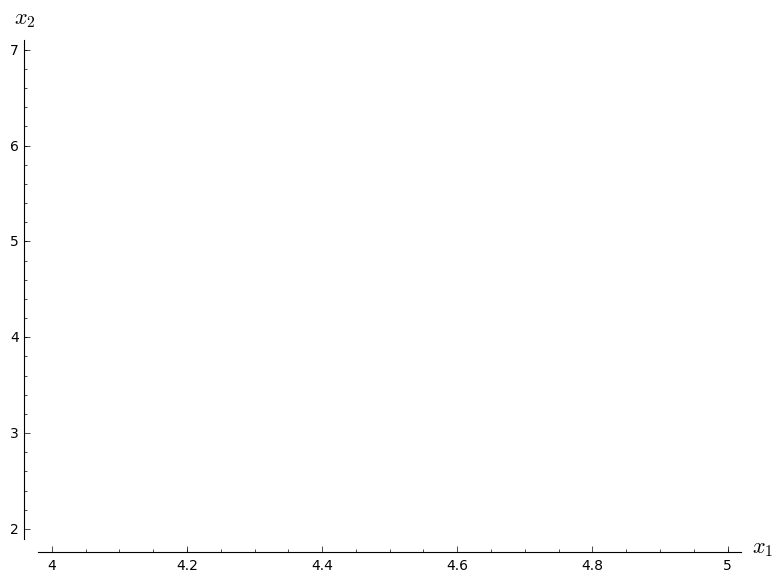

In [53]:
S_carl

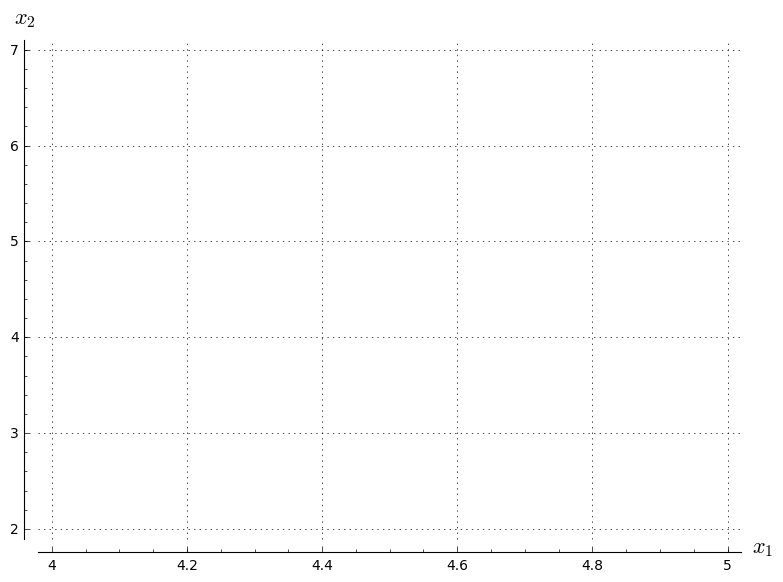

In [52]:
S_carl.show(gridlines=True, axes_labels = ['$x_1$', '$x_2$'], xmin=4, xmax=5, ymin=2, ymax=7)

4

In [ ]:
from carlin.transformation import truncated_matrix, kron_power

# truncation order
N = 2

AN = truncated_matrix(N, 'vanderpol.sage')

# cast into Sage dense matrix
AN = matrix(AN.toarray())

AN.nrows(), AN.ncols()

In [ ]:
ssplot = Graphics()

# initial condition
ssplot += point(x0, marker='x', color='red')

# solution of the ODE in phase space
x1x2 = [S.solution[i][1] for i in range(len(S.solution))]
ssplot += list_plot(x1x2, plotjoined=True)

ssplot.show(gridlines=True, axes_labels = ['$x_1$', '$x_2$'])

In [79]:
class PolynomialODE(SageObject):
    def __init__(self, equations=None):
        
        if equations is not None:
            self.equations = f
            ## stuff
            
    def show():
        """
        LaTeX representation of the polynomial system of ODE's.
        """
        return 1

    def solve():
        """
        xyz
        """
    
    def carleman_linearization(N, x0):
        """
        Carleman linearization
        """

In [80]:
PolynomialODE()

<class '__main__.PolynomialODE'>